# Coursework 1
**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Linear regression and feature selection <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
  - [(1.4)](#task-14) <a name="index-task-14"></a>
- [Task 2](#task-2): Non-linear regression with Kernel Ridge Regression <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>
- [Task 3](#task-3): Classification with the Multi-Layer Perceptron <a name="index-task-3"></a>
  - [(3.1)](#task-31) <a name="index-task-31"></a>
  - [(3.2)](#task-32)  <a name="index-task-32"></a>



---



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

rng = np.random.default_rng(0)

<a name="task-1"></a>

# Task 1: Linear regression and feature selection [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

We define $y'$ and $X'$ in a manner that lets us use the formulation for LASSO gradient descent. To be specific, we have $y' = \frac{1}{\sqrt{N^{train}}}y - \hat{\beta}^{LS}_0$ and $X' = \frac{1}{\sqrt{N^{train}}}X diag(\hat{\beta}^{LS})$, where $diag(u)$ is the square diagonal matrix with $X_{ii} = u_i$ as its diagonal entries.

In [2]:
## EDIT THIS FUNCTION
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma
    return X_std

In [3]:
def basic_graph(x, ys, labels, *, xlog=False, ylog=False, symlog=False, xlabel=None, ylabel=None):
    plt.figure(figsize=(12,8))
    for i, y in enumerate(ys.T):
        plt.plot(x, y, markersize=10, label=labels[i])
    plt.xlabel("x")
    plt.ylabel("y")
    if xlog:
        plt.xscale("log")
    if ylog:
        plt.yscale("log")
    if symlog:
        plt.yscale("symlog", linthresh=0.1)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [4]:
def r2_score(y, y_hat):
    """R^2 score to assess regression performance."""

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [5]:
def ls(x_train, y):
    assert x_train.shape[0] == y.shape[0], "x_train and y_train must have same size"
    X = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
    XX = X.T @ X
    Xy = X.T @ y
    return np.linalg.inv(XX) @ Xy

In [6]:
def garrote(x_train, y_train, lambd, n_iters=10000, step_size=10**(-7), c_huber=10**(-4)):

    assert x_train.shape[0] == y_train.shape[0], "x_train and y_train must have same size"


    n, p = x_train.shape

    ls_coeffs = ls(x_train, y_train)
    g = np.zeros(p)

    beta_ls_0 = ls_coeffs[0]
    beta_ls = ls_coeffs[1:]

    # redefinitions of y_dash and X_dash so scheme can work with LASSO definition
    y_dash = (1 / np.sqrt(n)) * (y_train - beta_ls_0)
    X_dash = (1 / np.sqrt(n)) * (x_train @ np.diag(beta_ls))

    for i in range(n_iters):
        grad_c = grad_huber(g, c_huber)
        grad_c[0] = 0

        grad = 2 * (X_dash.T @ X_dash @ g - X_dash.T @ y_dash) + lambd * grad_c

        g -= step_size * grad

    return g, beta_ls

In [7]:
def huber(beta, c=10**(-6)):
    return np.where(np.abs(beta) <= c, (beta**2)/2, c * (np.abs(beta) - c/2))

def grad_huber(beta, c=10**(-6)):
    g = np.empty_like(beta)
    return np.where(np.abs(beta) < c, beta, c * np.sign(beta))

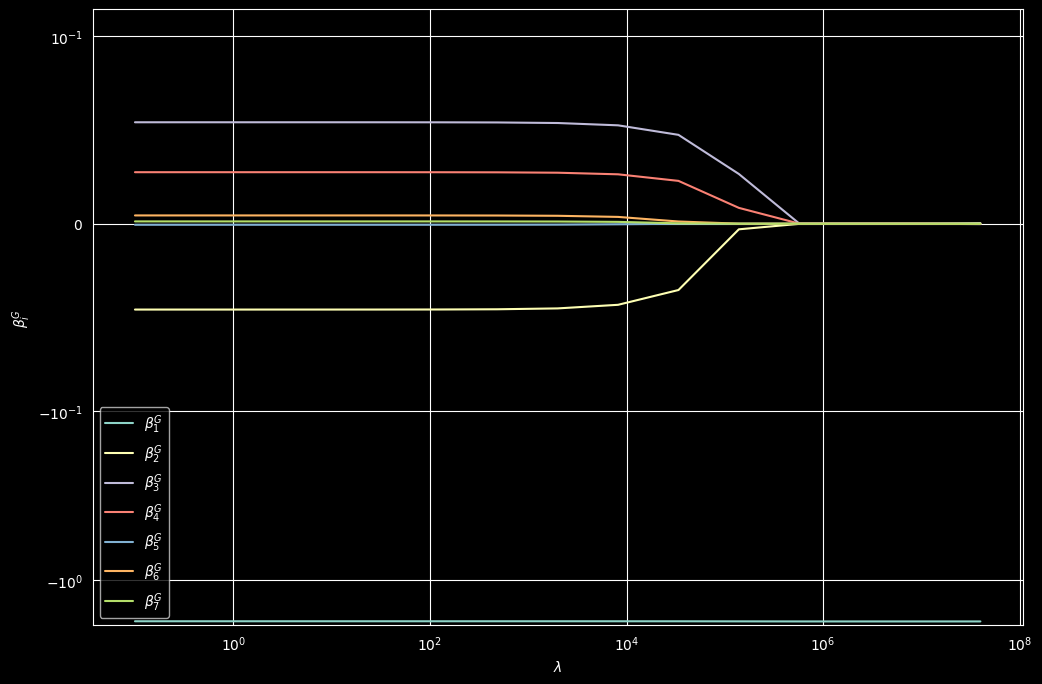

In [8]:
test_df = pd.read_csv('asteroid_observations_test.csv')
train_df = pd.read_csv('asteroid_observations_train.csv')

lambdas = np.logspace(-1, 7.6, 15)

x_train_u = train_df.to_numpy()[:, :7].astype(float)
y_train = train_df.to_numpy()[:, 7].astype(float)
x_test_u = test_df.to_numpy()[:, :7].astype(float)
y_test = test_df.to_numpy()[:, 7].astype(float)

x_train = standardise(x_train_u)
x_test = standardise(x_test_u, X_train_=x_train_u)

beta_mat = np.zeros((15, 7))

for i, lambd in enumerate(lambdas):
    garrote_constants, betas = garrote(x_train, y_train, lambd)
    beta_g = np.diag(betas) @ garrote_constants
    beta_mat[i, :] = 1.0 * beta_g

basic_graph(lambdas, beta_mat, labels=[rf"$\beta^G_{i+1}$" for i in range(7)], xlog=True, symlog=True, xlabel=r"$\lambda$", ylabel=r"$\beta^G_i$")

Using this, we can very clearly see some feature selection -- feature $1$ remains significant even for high values of $\lambda$, whereas the other coefficients drop to $0$ at $\lambda = 10^4$ for more insignificant features such as features $5$, $6$, and $7$, and at around $\lambda = 10^5$ for the other, slightly more significant features $2$, $3$ and $4$, which are clearly still significant.

<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

In [9]:
def garrote_fun(x, beta_g, beta_ls):
    return x.T @ beta_g + beta_ls[0]

def folds(y, T):
    n = y.shape[0]
    return np.split(np.arange(n - n % T), T)

fold_2 = folds(y_train, 2)
fold_20 = folds(y_train, 20)

In [10]:
def validation_MSE(x_train, y_train, folds, lambd):
    vals = np.zeros(len(folds))
    for i, fold in enumerate(folds):
        test_indices = np.concatenate([f for j, f in enumerate(folds) if j != i])
        s_t = test_indices.shape[0]
        g_c, betas = garrote(x_train[test_indices, :], y_train[test_indices], lambd)
        vals[i] = 1 / s_t * np.sum([garrote_fun(x_train[ind, :], g_c, betas) ** 2 for ind in test_indices])
    return vals

In [11]:
def successive_difference(scores):
    T = len(scores)
    tot = 0
    for i in range(1, T):
        tot += abs(scores[i] - scores[i - 1])
    return tot / (T - 1)

In [12]:
Ds = np.zeros((2, len(lambdas)))

for i, lambd in enumerate(lambdas):
    MSE_t_2 = validation_MSE(x_train, y_train, fold_2, lambd)
    MSE_t_20 = validation_MSE(x_train, y_train, fold_20, lambd)

    Ds[0, i] = successive_difference(MSE_t_2)
    Ds[1, i] = successive_difference(MSE_t_20)

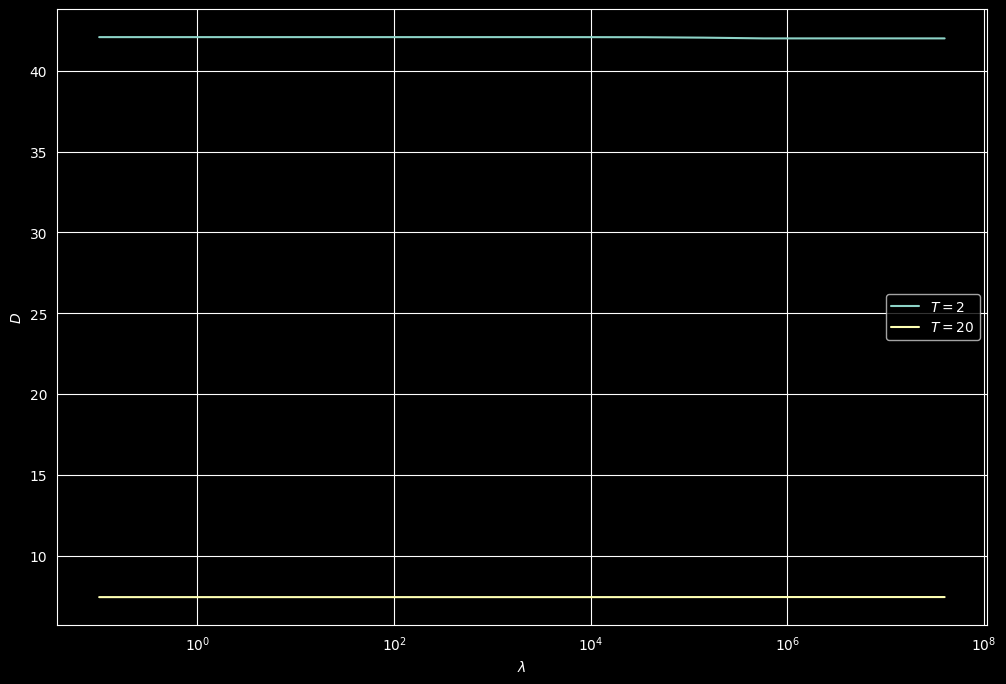

In [13]:
basic_graph(lambdas, Ds.T, labels=[r"$T = 2$", r"$T = 20$"], xlog=True, xlabel=r"$\lambda$", ylabel=r"$D$")

Since the graph is completely flat for both $T=2$ and $T=20$, we see that our implementation is very stable -- the validation $MSE$ score doesn't wildly change between successive folds. The difference for $T=2$ is higher than for $T=20$, this is due to the larger sample size.

<a name="task-13"></a>

## (1.3) [(index)](#index-task-13)

In [14]:
def minimize_ls_huber(X, y, lambd, n_iters = 10000, step_size=10**(-7), c_huber=10**(-4)):
    """
    This function estimates the regression parameters with the relaxed version
    of LASSO regression using the gradient-descent algorithm to find the optimal
    solution.
    Args:
    X (np.array): The augmented data matrix with shape (N, p + 1).
    y (np.array): The response column with shape (N, 1).
    lambd (float): The multiplier of the relaxed L1 term.
    n_iters (int): Number of gradient descent iterations.
    step_size (float): The step size in the updating step.
    """

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    # Precomputed products to avoid redundant computations.
    XX = X.T @ X
    Xy = X.T @ y
    # Initialize beta params with zeros
    beta = np.zeros(p)

    for i in range(n_iters):
        # Compute the gradient of the relaxed LASSO, Huber.
        grad_c = grad_huber(beta, c=c_huber)

        # Intercept term is not involved in the regularisation.
        grad_c[0] = 0

        # Compute the gradient of the regularised loss.
        grad = 2 / N * (XX @ beta - Xy) + lambd * grad_c

        # Update beta
        beta = beta - step_size * grad

    return beta

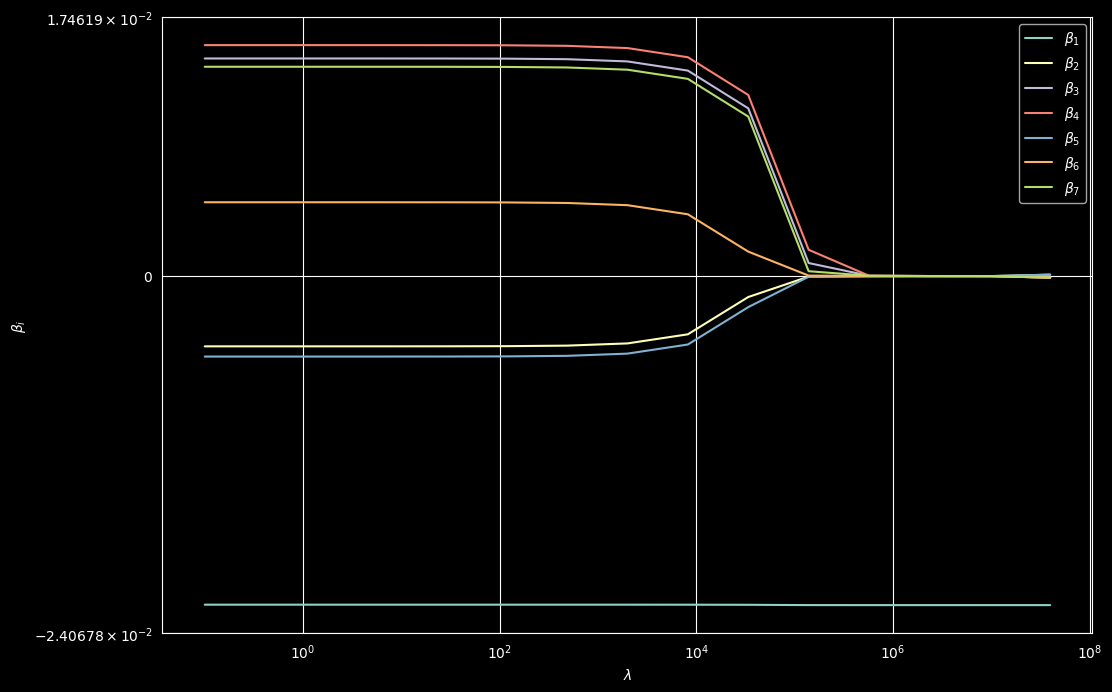

In [15]:
beta_mat = np.zeros((15, 7))

for i, lambd in enumerate(lambdas):
    betas = minimize_ls_huber(x_train, y_train, lambd)
    beta_mat[i, :] = 1.0 * betas

basic_graph(lambdas, beta_mat, labels=[rf"$\beta_{i+1}$" for i in range(7)], xlog=True, symlog=True, xlabel=r"$\lambda$", ylabel=r"$\beta_i$")

We can see here that on average, the coefficients from the Garrote method are higher on average -- one can see that raising the step-size in LASSO yields results more similar to Garrote. LASSO also holds more weight in the coefficients other than $\beta_1$, which implies that it is superior in performing feature selection, as Garrote tends to weed out any kind of feature that doesn't have significant importance, even at low $\lambda$.

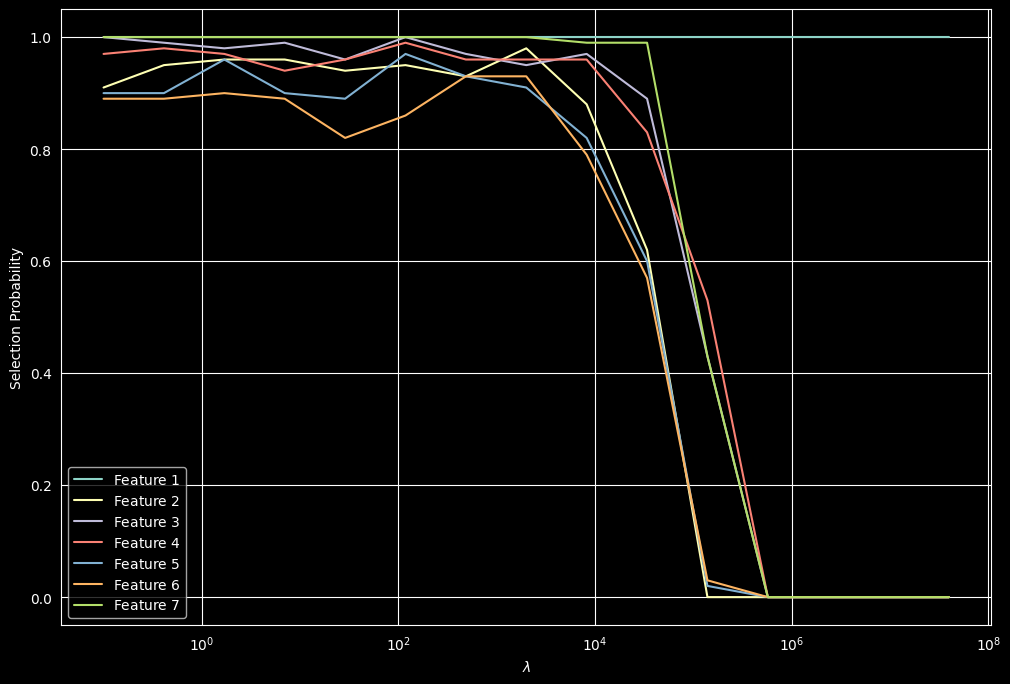

In [16]:
training_indices = np.arange(y_train.shape[0])
lambdas = np.logspace(-1, 7.6, 15)
def bootstrap_lasso(B, X, y, lambd, N):
    selected = np.zeros(7)
    for _ in range(B):
        sample = rng.choice(training_indices, N, replace=False)
        X_sample = X[sample, :]
        y_sample = y[sample]
        coeffs = minimize_ls_huber(X_sample, y_sample, lambd)
        for i in range(len(coeffs)):
            if abs(coeffs[i]) > 0.001:
                selected[i] += 1
    return selected/B
traj = []
for lambd in lambdas:
    traj.append(bootstrap_lasso(100, x_train, y_train, lambd, 50))
traj = np.array(traj)
basic_graph(lambdas, traj, labels=[rf"Feature ${i+1}$" for i in range(7)], xlog=True, xlabel=r"$\lambda$", ylabel="Selection Probability")

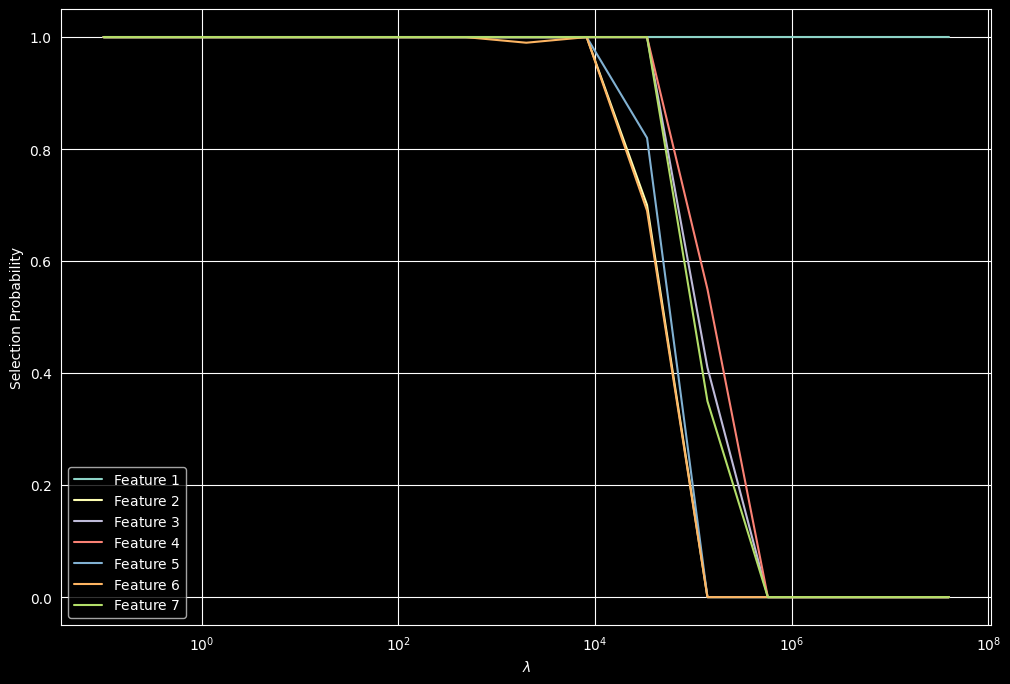

In [17]:
traj_2 = []
for lambd in lambdas:
    traj_2.append(bootstrap_lasso(100, x_train, y_train, lambd, y_train.shape[0]//2))
traj_2 = np.array(traj_2)
basic_graph(lambdas, traj_2, labels=[rf"Feature ${i+1}$" for i in range(7)], xlog=True, xlabel=r"$\lambda$", ylabel="Selection Probability")

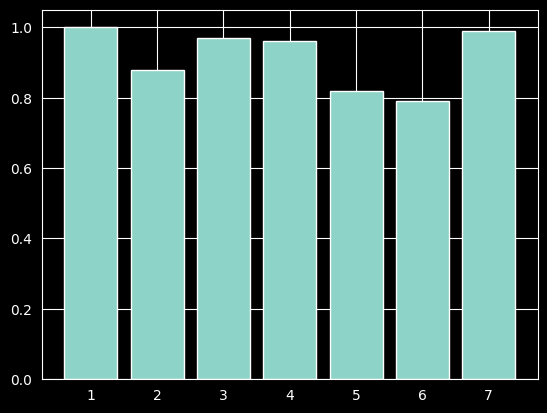

In [18]:
plt.bar(np.arange(1, 8), traj[8])
plt.show()

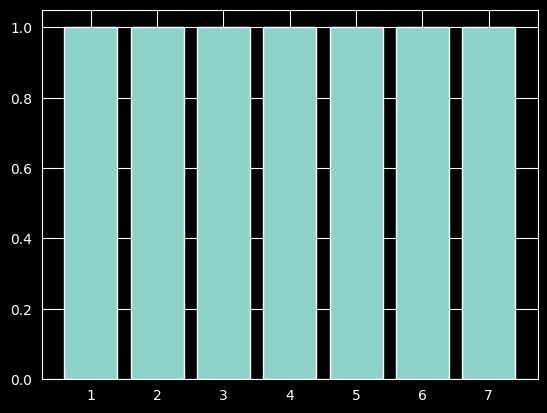

In [19]:
plt.bar(np.arange(1, 8), traj_2[8])
plt.show()

These plots showcase LASSO's stability on our dataset. Picking $N' = 50$ shows that each feature is selected above $80\%$ of the time, whereas picking the larger $N' = N^{train}/2 = 369$ yields a $100\%$ pick rate across all features. Since different sets of training data do not yield big differences in the selected features, we can clearly see that LASSO is relatively stable.

<a name="task-14"></a>

## (1.4) [(index)](#index-task-14)

In [20]:
def aug_max_lik_estimate(X, y):

    '''param X: N x p matrix of training inputs
    param y: N x 1 vector of training targets/observations
    return beta_ml: maximum likelihood parameters (p x 1)'''

    N = X.shape[0]

    # check X and y have the same length
    assert N == y.shape[0], "Input X and y have different lengths."

    X_aug = np.hstack([np.ones((N, 1)), X])

    beta = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ y)
    return beta

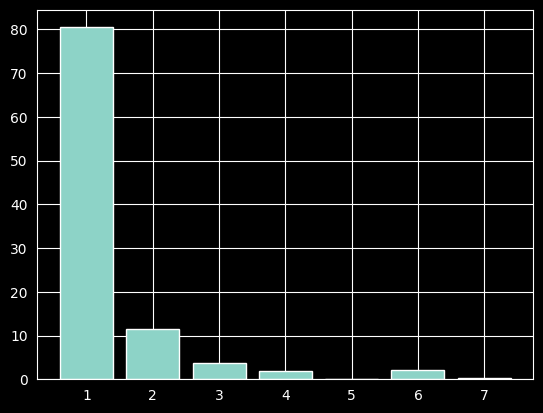

In [21]:
beta = aug_max_lik_estimate(x_train, y_train)
perm_ind = rng.permutation(len(y_test))
features = np.zeros((y_test.shape[0], 7))
importance = np.zeros(7)
for i in range(7):
    features[:, i] = x_test[:, i]
    features[:, i] = features[:, i][perm_ind]
    X_perm = np.copy(x_test)
    X_perm[:, i] = features[:, i]
    y_pred = [(x_test[i].T @ beta[1:] + beta[0]) for i in range(x_test.shape[0])]
    y_pred_perm = [(X_perm[i].T @ beta[1:] + beta[0]) for i in range(x_test.shape[0])]
    y_pred = np.array(y_pred)
    y_pred_perm = np.array(y_pred_perm)
    r2 = r2_score(y_test, y_pred)
    r2_perm = r2_score(y_test, y_pred_perm)
    importance[i] = abs(r2 - r2_perm)
importance /= sum(importance)
importance *= 100
plt.bar(np.arange(1, 8), importance)
plt.show()

This plot clearly shows that the most important feature by far is Feature $1$. This is supported by our findings from both LASSO and Garrote -- feature $1$ wasn't culled until very high values of $\lambda$, and had a substantially higher coefficient than any other feature. We also see that, as discussed in Task 1.1, features $2$, $3$ and $4$ hold some degree of importance. What Garrote failed to find is that feature $6$ is actually quite important -- in our Garrote setup, this feature had a very low coefficient.

<a name="task-2"></a>

# Task 2: Non-linear regression with Kernel Ridge Regression [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

In [22]:
x_bar = np.mean(x_train, axis=0)
y_bar = np.mean(y_train)
lambd = 0.1
betas = np.linalg.inv(x_train.T @ x_train + y_train.shape[0] * lambd * np.diag(np.ones(7))) @ x_train.T @ y_train
beta_0 = y_bar - np.dot(x_bar, betas)

To formulate the kernalised form of the Ridge regressor, we first define our kernel matrix $K_{ij}(x^{(1)}, x^{(2)}) = K(x^{(1)}_i, x^{(2)}_j)$, where $K(u, v)$ is a kernel function -- that is, one that is positive semi-definite.

In [23]:
def kernel_matrix(x1, x2, func, params):
    n1, m1 = x1.shape
    n2, m2 = x2.shape
    K = np.zeros((n1, n2))

    for i in range(n1):
        for j in range(n2):
            K[i, j] = func(x1[i, :], x2[j, :], *params)

    return K

In [24]:
def kernel_poly(v, z, n, c):
    return (v @ z.T + c) ** n

def kernel_rbf(v, z, sigma):
    expo = -np.linalg.norm(v - z) ** 2 / sigma
    return np.exp(expo)

def kernel_new(v, z, n, c, sigma):
    expo = kernel_poly(v, v, n, c) + kernel_poly(z, z, n, c) - 2 * kernel_poly(v, z, n, c)
    return np.exp(-expo/sigma)

With $K$ defined, we can find the analytical solution to our kernalised Ridge regressor. We know that the analytical solution to a regular Ridge regressor is $\hat{\beta} = (X^TX + \lambda I)^{-1}y$, with $\hat{y} = X\hat{\beta}$. By replacing all dot products $u \cdot v$ in our solution with $K(u, v)$ (or alternatively, $u^T v$) we get the solution $\alpha = (K(X, X) + \lambda I)^{-1}y$ with $\hat{y} = K(X^{(1)}, X^{(2)}) \alpha$, where $x^{(1)}$ is the set we wish to evaluate and $x^{(2)}$ is the set we trained the kernel on.

In [25]:
def kernel_ridge_regression(X, y, lambd, func, params):
    K = kernel_matrix(X, X, func, params)
    n = K.shape[0]
    alphas = np.linalg.solve(K + lambd * np.eye(n), y)

    return alphas

In [26]:
def kernel_ridge_regression_prediction(X, x_train, alphas, func, params):
    K_test = kernel_matrix(X, x_train, func, params)

    return K_test @ alphas

In [27]:
print(r2_score(y_train, x_train @ betas + beta_0))

0.7504658147646939


In [28]:
print(r2_score(y_test, x_test @ betas + beta_0))

0.746036091143093


In [29]:
def r2_score_kernel(x_train, y_train, x_test, y_test, lambd, kernel, params):
    alphas = kernel_ridge_regression(x_train, y_train, lambd, kernel, params)
    y_pred_train = kernel_ridge_regression_prediction(x_train, x_train, alphas, kernel, params)
    y_pred_test = kernel_ridge_regression_prediction(x_test, x_train, alphas, kernel, params)
    return (r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)), alphas

In [31]:
n, c = 2, 0
score, _ = r2_score_kernel(x_train, y_train, x_test, y_test, lambd, kernel_poly, [n, c])
print(score)

(np.float64(0.7660712516230657), np.float64(0.6309161073316083))


In [32]:
n, c = 2, 1
score, _ = r2_score_kernel(x_train, y_train, x_test, y_test, lambd, kernel_poly, [n, c])
print(score)

(np.float64(0.9685107715674917), np.float64(0.954340312482086))


In [33]:
n, c = 3, 1
score, _ = r2_score_kernel(x_train, y_train, x_test, y_test, lambd, kernel_poly, [n, c])
print(score)

(np.float64(0.9938072543124857), np.float64(0.981562928597753))


We can see that the $R^2$ scores are much higher for $c = 1$ than for $c = 0$, and using $n = 3$ provides a slight increase in precision than $n = 2$. We also see that this kernelised version of Ridge yields a much better $R^2$ score than the regular Ridge regressor.\hat{\beta}

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

In [34]:
x_train_red = x_train[:, :2]
x_test_red = x_test[:, :2]

In [48]:
def plot_kernel_3d(x_train_red, y_train, alphas, kernel, params, gridsize=50):
    x1 = x_train_red[:, 0]
    x2 = x_train_red[:, 1]

    x1_grid = np.linspace(x1.min(), x1.max(), gridsize)
    x2_grid = np.linspace(x2.min(), x2.max(), gridsize)
    x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)

    x_grid = np.column_stack([x1_mesh.ravel(), x2_mesh.ravel()])

    y_grid_pred = kernel_ridge_regression_prediction(x_grid, x_train_red, alphas, kernel, params).reshape(gridsize, gridsize)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x1_mesh, x2_mesh, y_grid_pred, alpha=0.7, rstride=1, cstride=1)

    ax.scatter(x1, x2, y_train, color="blue", s=20, label="Training")

    ax.set_xlabel("Absolute magnitude (standardized)")
    ax.set_ylabel("Albedo (standardized)")
    ax.set_zlabel("Asteroid diameter")

    ax.set_title(f"KRR fit ({kernel.__name__}, lambda={lambd})")
    ax.legend()

    plt.show()



In [55]:
N, C, SIGMA = 2, 1, 20

lambd = 0.1

score, alphas = r2_score_kernel(x_train_red, y_train, x_test_red, y_test, lambd, kernel_poly, [N, C])
print(score)

(np.float64(0.9536719329953098), np.float64(0.9399745668160336))


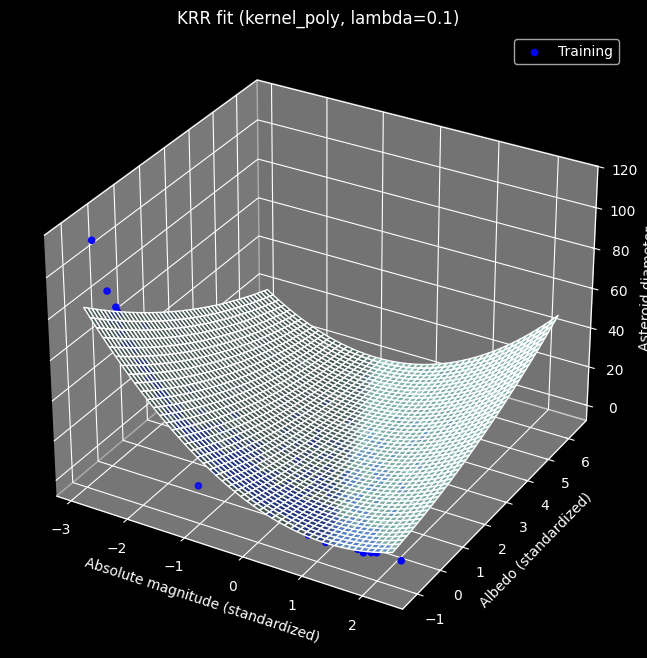

In [56]:
plot_kernel_3d(x_train_red, y_train, alphas, kernel_poly, [N, C])

In [57]:
score, alphas = r2_score_kernel(x_train_red, y_train, x_test_red, y_test, lambd, kernel_rbf, [SIGMA])
print(score)

(np.float64(0.9731948934994996), np.float64(0.9711031114705811))


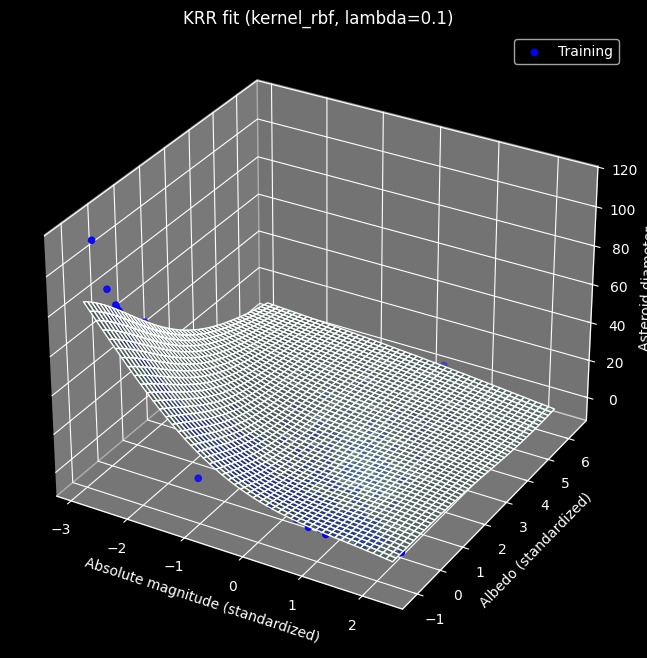

In [58]:
plot_kernel_3d(x_train_red, y_train, alphas, kernel_rbf, [SIGMA])

In [59]:
score, alphas = r2_score_kernel(x_train_red, y_train, x_test_red, y_test, lambd, kernel_new, [N, C, SIGMA])
print(score)

(np.float64(0.9885518902312994), np.float64(0.9937147608059922))


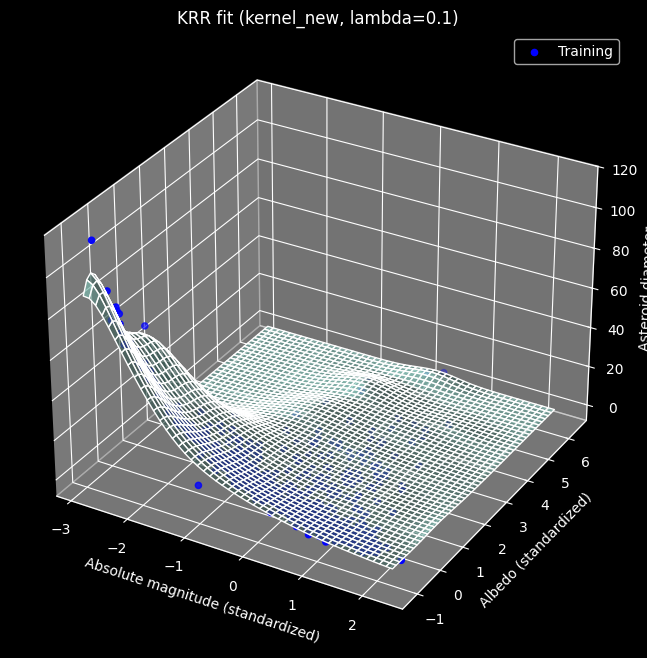

In [60]:
plot_kernel_3d(x_train_red, y_train, alphas, kernel_new, [N, C, SIGMA])

In [61]:
lambd = 300

score, alphas = r2_score_kernel(x_train_red, y_train, x_test_red, y_test, lambd, kernel_poly, [N, C])
print(score)

(np.float64(0.9129970319133289), np.float64(0.8870532916392998))


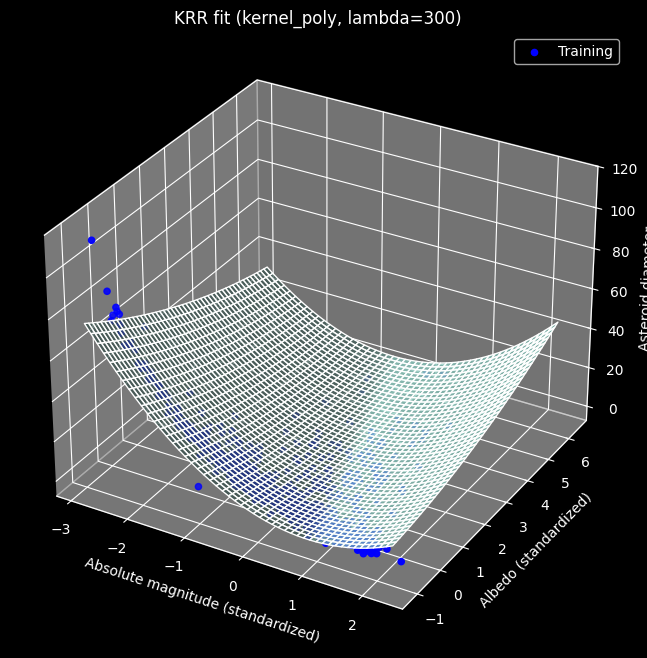

In [62]:
plot_kernel_3d(x_train_red, y_train, alphas, kernel_poly, [N, C])

In [63]:
score, alphas = r2_score_kernel(x_train_red, y_train, x_test_red, y_test, lambd, kernel_rbf, [SIGMA])
print(score)

(np.float64(0.03444744260230148), np.float64(0.05111956186305289))


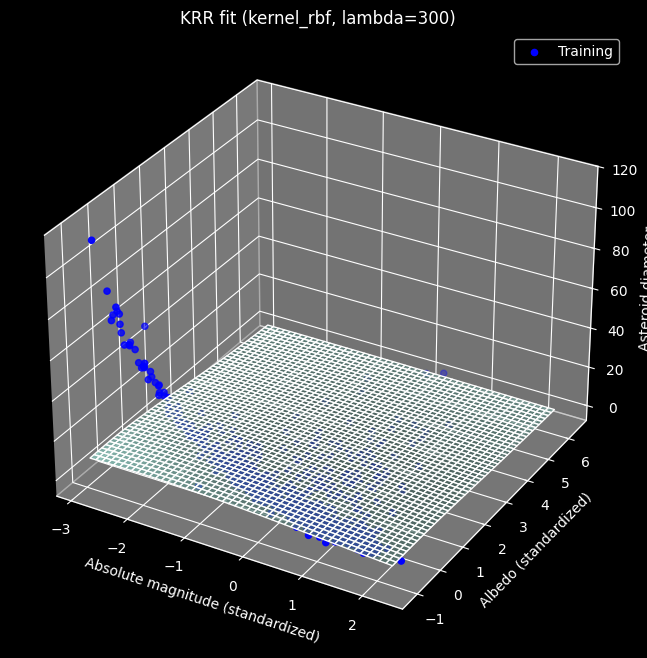

In [64]:
plot_kernel_3d(x_train_red, y_train, alphas, kernel_rbf, [SIGMA])

In [66]:
score, alphas = r2_score_kernel(x_train_red, y_train, x_test_red, y_test, lambd, kernel_new, [N, C, SIGMA])
print(score)

(np.float64(-0.1034696631532499), np.float64(-0.0874314504049647))


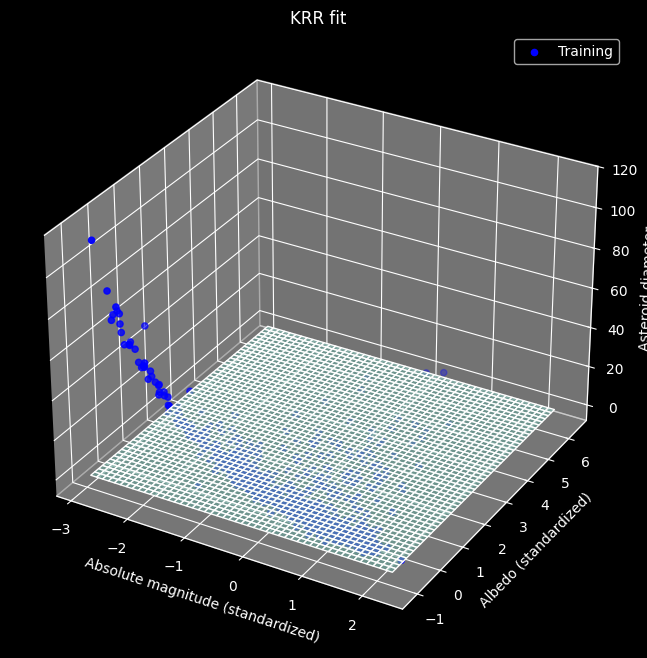

In [53]:
plot_kernel_3d(x_train_red, y_train, alphas, kernel_new, [N, C, SIGMA])

We can immediately see that $\lambda = 0.1$ yields a much better result than $\lambda = 300$, in fact, the latter two kernels ($k^{RBF}$ $k^{new}$) both fail to match the data under $\lambda = 300$, as the features get flattened to almost $0$. With $\lambda = 0.1$, we can see that $k^{new}$ performs the best by looking at the $R^2$ score, then $k^{RBF}$ performs next best, while $k^{P}$ performs worst (although still performs well with an $R^2$ score of $0.97$)

<a name="task-3"></a>

# Task 3: Classification with the Multi-Layer Perceptron [(index)](#index-task-3)

<a name="task-31"></a>

## (3.1) [(index)](#index-task-31)

In [ ]:
x_train_u = train_df.to_numpy()[:, :7].astype(float)
x_test_u = test_df.to_numpy()[:, :7].astype(float)

onehot_dict = {"MBA": np.array([1.0, 0, 0]),
               "TJN": np.array([0, 1.0, 0]),
               "OMB": np.array([0, 0, 1.0])}

y_train = np.array([onehot_dict[label] for label in train_df.to_numpy()[:, 8]])
y_test = np.array([onehot_dict[label] for label in test_df.to_numpy()[:, 8]])

x_train = standardise(x_train_u)
x_test = standardise(x_test_u, X_train_=x_train_u)

In [ ]:
## EDIT THIS FUNCTION
def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in is the input dimension.
        W (np.ndarray): h_out x h_in array for weights matrix parameters, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X]) ## <-- SOLUTION
    return a

## EDIT THIS FUNCTION
def relu_activation(a):
    """ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.maximum(a, 0.)  ## <-- SOLUTION
    return h

## EDIT THIS FUNCTION
def grad_relu_activation(a):
    """Gradient of ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = np.zeros_like(a) ## <-- SOLUTION
    grad[a>0] = 1 ## <-- SOLUTION
    return grad

def softmax(a):
    a -= np.max(a) * np.ones_like(a)
    return np.exp(a) / np.sum(np.exp(a), axis=1, keepdims=True)

def mse_loss(y_true, y_pred):
    """Compute MSE-loss

    Parameters:
        y_true: ground-truth array, with shape (K, )
        y_pred: predictions array, with shape (K, )

    Returns:
        loss (float): MSE-loss
    """
    assert y_true.shape == y_pred.shape, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    # Compute MSE loss
    loss = np.mean((y_true - y_pred)**2, keepdims=True)
    return loss

def grad_mse_loss(y_true, y_pred):
    """Compute gradient of MSE-loss

    Parameters:
        y_true: ground-truth values, shape: (K, ).
        y_pred: prediction values, shape: (K, ).

    Returns:
        grad (np.ndarray): Gradient of MSE-loss, shape: (K, ).
    """
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    # Compute gradient of MSE loss
    grad = 2.0 * (y_pred - y_true) / y_true.size
    return grad

def cross_entropy_loss(y, y_hat):
    y_hat_soft = softmax(y_hat)
    loss = -np.sum(y * np.log(y_hat_soft))
    return loss

def grad_cross_entropy_loss(y, y_hat):
    y_hat_soft = softmax(y_hat)
    return y_hat_soft - y

# A lookup table for activation functions by their names.
activation_table = {
    "relu": relu_activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "relu": grad_relu_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}

training_table = {
    "mse": mse_loss,
    "ce": cross_entropy_loss
}

grad_training_table = {
    "mse": grad_mse_loss,
    "ce": grad_cross_entropy_loss
}

class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers (including input and output)."""
        return len(self.layers) + 1 if len(self.layers) > 0 else 0

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The input dimension of the layer.
            out_dim (int): The output dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            # hint: use self.rng.normal()
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim),
            # store the activation function (as string)
            "activation": activation
        })

    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]]
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"])
        # predicted target is output of last layer
        return y_hat, forward_pass

def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions, has the shape (K, 1), where K is the batch size.
    Returns:
        gradients (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric in the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    gradients = []

    # Initialise delta.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):   # zip iterates through pairs of layers and forward_pass
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."

        # Gradients are average gradients over batch
        gradients.append({"W" : (delta.T @ h) / h.shape[0],
                          "b" : delta.mean(axis=0)})

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)])


    # Return now ordered list matching the layers.
    gradients = list(reversed(gradients))
    return gradients

def sgd_step(X, y, mlp, learning_rate = 1e-3, fun = "mse"):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, p).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        updated_layers (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X)

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_training_table[fun](y, y_hat)

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"]
        b = layer["b"] - learning_rate * grad["b"]
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers

def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 1e-3,
        n_epochs=10, minibatchsize=1, seed=42, fun = "mse"):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (N^{training}, p).
        y_train (np.ndarray): The training data ground-truth, with shape (N^{training}, 1).
        X_test (np.ndarray): The testing data features, with shape (N^{test}, p).
        y_test (np.ndarray): The testing data ground-truth, with shape (N^{test}, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.

    Returns:
        mlp (MLP): MLP object encapuslating the trained MLP model.
        losses_train (np.ndarray): Train losses over epochs.
        losses_tset (np.ndarray): Test losses over epochs.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    counts = np.zeros((6, n_epochs))

    for i in range(n_epochs):

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate, fun)

            # update weights and biases of MLP
            mlp.layers = updated_layers

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        loss_train = training_table[fun](y_train, y_hat_train).squeeze()
        losses_train.append(loss_train)

        y_hat_test, _ = mlp.predict(X_test)
        loss_test = training_table[fun](y_test, y_hat_test).squeeze()
        losses_test.append(loss_test)

        if (i==0) or ((i+1)%(n_epochs//10)==0):
          print(
              f'Epoch {i+1}/{n_epochs}: In-sample error: {loss_train}, Out-of-sample error: {loss_test}'
               )

    return mlp, losses_train, losses_test


In [ ]:
mlp = MLP(seed=2)
mlp.add_layer(7, 64)
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 32, "relu")
mlp.add_layer(32, 3, "relu")

mlp, losses_train, losses_test = sgd(x_train, y_train, x_test, y_test, mlp, learning_rate=0.04, n_epochs=500, minibatchsize=64, seed=42, fun="ce")

In [ ]:
# plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,501),losses_train, label="Train")
ax.plot(np.arange(1,501),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "Total CE")
ax.legend()
plt.show()

As we can see, the model takes around $200$ epochs to converge for the test set, and around $400$-$500$ to converge for the training set. As expected, the performance on the training set is better than on the test set, however we achieve a total cross-entropy of around $15$, which yields an average entropy of around $0.1$, which indicates good performance, as anything less than $\log(3) \approx 1.098$ indicates that the model performs better than random choices.

In [ ]:
def class_accuracy(y_softmax, y_test, print_output=False):
    classes = (np.where(np.all(y_test == [1, 0, 0],axis=1))[0], np.where(np.all(y_test == [0, 1, 0],axis=1))[0], np.where(np.all(y_test == [0, 0, 1],axis=1))[0])

    realisation = np.zeros_like(y_softmax)
    count_vec = np.zeros(y_softmax.shape[0])
    for i in range(y_softmax.shape[0]):
        pick = rng.choice(3, p=y_softmax[i, :])
        realisation[i, pick] = 1
        count_vec[i] = pick

    for j, q in enumerate(classes):
        count = 0
        for i in q:
            if np.all(realisation[i, :] == y_test[i, :]):
                count += 1
        if print_output:
            print(f"class {j + 1}: {count / len(q)}")

    return count_vec

y_pred, _ = mlp.predict(x_test)
counts = class_accuracy(softmax(y_pred), y_test, print_output=True)

In [ ]:
classes = (np.where(np.all(y_test == [1, 0, 0],axis=1))[0], np.where(np.all(y_test == [0, 1, 0],axis=1))[0], np.where(np.all(y_test == [0, 0, 1],axis=1))[0])

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i, q in enumerate(classes):
    ax = axs[i, 0]
    ax.hist(counts[q], bins=3)
    ax.set_xticks([])
    ax.set_title(f"Realisations of class {i} evaluated on class {i}")

    ax = axs[i, 1]
    counts_not_q = np.concatenate([counts[classes[i-1]], counts[classes[i-2]]])
    ax.hist(counts_not_q, bins=3)
    ax.set_xticks([])
    ax.set_title(f"Realisations of class {i} evaluated on classes {(i-1) % 3} and {(i-2) % 3}")

fig.show()

From these results, we can see that the MLP performs well in our test set. There are some small inaccuracies: for example, asteroids of class $2$ (OMB - Outer Main Belt) are commonly misidentified as class $0$ (MBA - Main Belt), and vice versa, albeit at a slightly lower rate. This occurs approximately $10$-$20\%$ of the time. Asteroids belonging to class $1$ (TJN - Trojan) are always correctly identified. Looking at the data shows why this may be -- asteroids with higher diameter (and hence higher absolute magnitude) tend to belong to class TJN.

<a name="task-32"></a>

## (3.2) [(index)](#index-task-32)

In [ ]:
def train_weak_model(x_train, y_train, x_test, y_test):
    mlp = MLP(seed=2)
    mlp.add_layer(7, 32)
    mlp.add_layer(32, 32, "relu")
    mlp.add_layer(32, 16, "relu")
    mlp.add_layer(16, 3, "relu")

    mlp, _, _ = sgd(x_train, y_train, x_test, y_test, mlp, learning_rate=0.05, n_epochs = 100, minibatchsize=32, seed=42, fun="mse")

    return mlp

In [ ]:
NU = 2

y_pred_train_raw, _ = mlp.predict(x_train)
y_pred_test_raw, _ = mlp.predict(x_test)

y_pred_train = softmax(y_pred_train_raw)
y_pred_test = softmax(y_pred_test_raw)


y_p_temp = 1.0 * y_pred_test

pr_train = y_train - y_pred_train # difference between predicted values and actual values (pseudoresidual)
pr_test = y_test - y_pred_test

for i in range(4):
    mlp_weak = train_weak_model(x_train, pr_train, x_test, pr_test)

    predicted_train_residuals, _ = mlp_weak.predict(x_train)
    predicted_test_residuals, _ = mlp_weak.predict(x_test)

    y_pred_train_raw += NU * predicted_train_residuals
    y_pred_test_raw += NU * predicted_test_residuals

    y_pred_train = softmax(y_pred_train_raw)
    y_pred_test = softmax(y_pred_test_raw)

    pr_train = y_train - y_pred_train
    pr_test = y_test - y_pred_test

    class_accuracy(y_pred_test, y_test)

We can see that, since our model is already good at identifying the classes of asteroids, gradient boosting does not provide much benefit. Some inspection of the data shows however that it does provide a meaningful improvement, however the model is already good, and so comparatively it does not do much. Gradient descent would see much more use with a worse initial guess.